In [1]:
!pip install kagglehub scikit-learn pandas numpy matplotlib seaborn plotly xgboost lightgbm
!pip install ibm-watson-machine-learning ibm-cos-sdk flask

# Import libraries
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.inspection import permutation_importance
import xgboost as xgb
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

print("✅ All packages installed successfully!")

✅ All packages installed successfully!


In [2]:
 #PART 2: DATA LOADING AND EXPLORATION
# =====================================================

# Download dataset from Kaggle
print("📥 Downloading dataset...")
path = kagglehub.dataset_download("patelris/crop-yield-prediction-dataset")
print(f"📍 Dataset path: {path}")

# Load the dataset
import os
csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]
print(f"📋 Available files: {csv_files}")

# Load the main dataset
df = pd.read_csv(os.path.join(path, csv_files[0]))
print("✅ Dataset loaded successfully!")

# Display basic information
print(f"\n📊 Dataset Shape: {df.shape}")
print(f"📋 Columns: {list(df.columns)}")
print(f"\n🔍 First 5 rows:")
print(df.head())

print(f"\n📈 Dataset Info:")
df.info()

print(f"\n📊 Statistical Summary:")
print(df.describe())

# Check for missing values
print(f"\n🔍 Missing Values:")
print(df.isnull().sum())

📥 Downloading dataset...


100%|██████████| 959k/959k [00:00<00:00, 86.9MB/s]

Extracting files...
📍 Dataset path: /root/.cache/kagglehub/datasets/patelris/crop-yield-prediction-dataset/versions/1
📋 Available files: ['pesticides.csv', 'rainfall.csv', 'temp.csv', 'yield_df.csv', 'yield.csv']
✅ Dataset loaded successfully!

📊 Dataset Shape: (4349, 7)
📋 Columns: ['Domain', 'Area', 'Element', 'Item', 'Year', 'Unit', 'Value']

🔍 First 5 rows:
           Domain     Area Element                Item  Year  \
0  Pesticides Use  Albania     Use  Pesticides (total)  1990   
1  Pesticides Use  Albania     Use  Pesticides (total)  1991   
2  Pesticides Use  Albania     Use  Pesticides (total)  1992   
3  Pesticides Use  Albania     Use  Pesticides (total)  1993   
4  Pesticides Use  Albania     Use  Pesticides (total)  1994   

                           Unit  Value  
0  tonnes of active ingredients  121.0  
1  tonnes of active ingredients  121.0  
2  tonnes of active ingredients  121.0  
3  tonnes of active ingredients  121.0  
4  tonnes of active ingredients  201.0  

📈 Dat

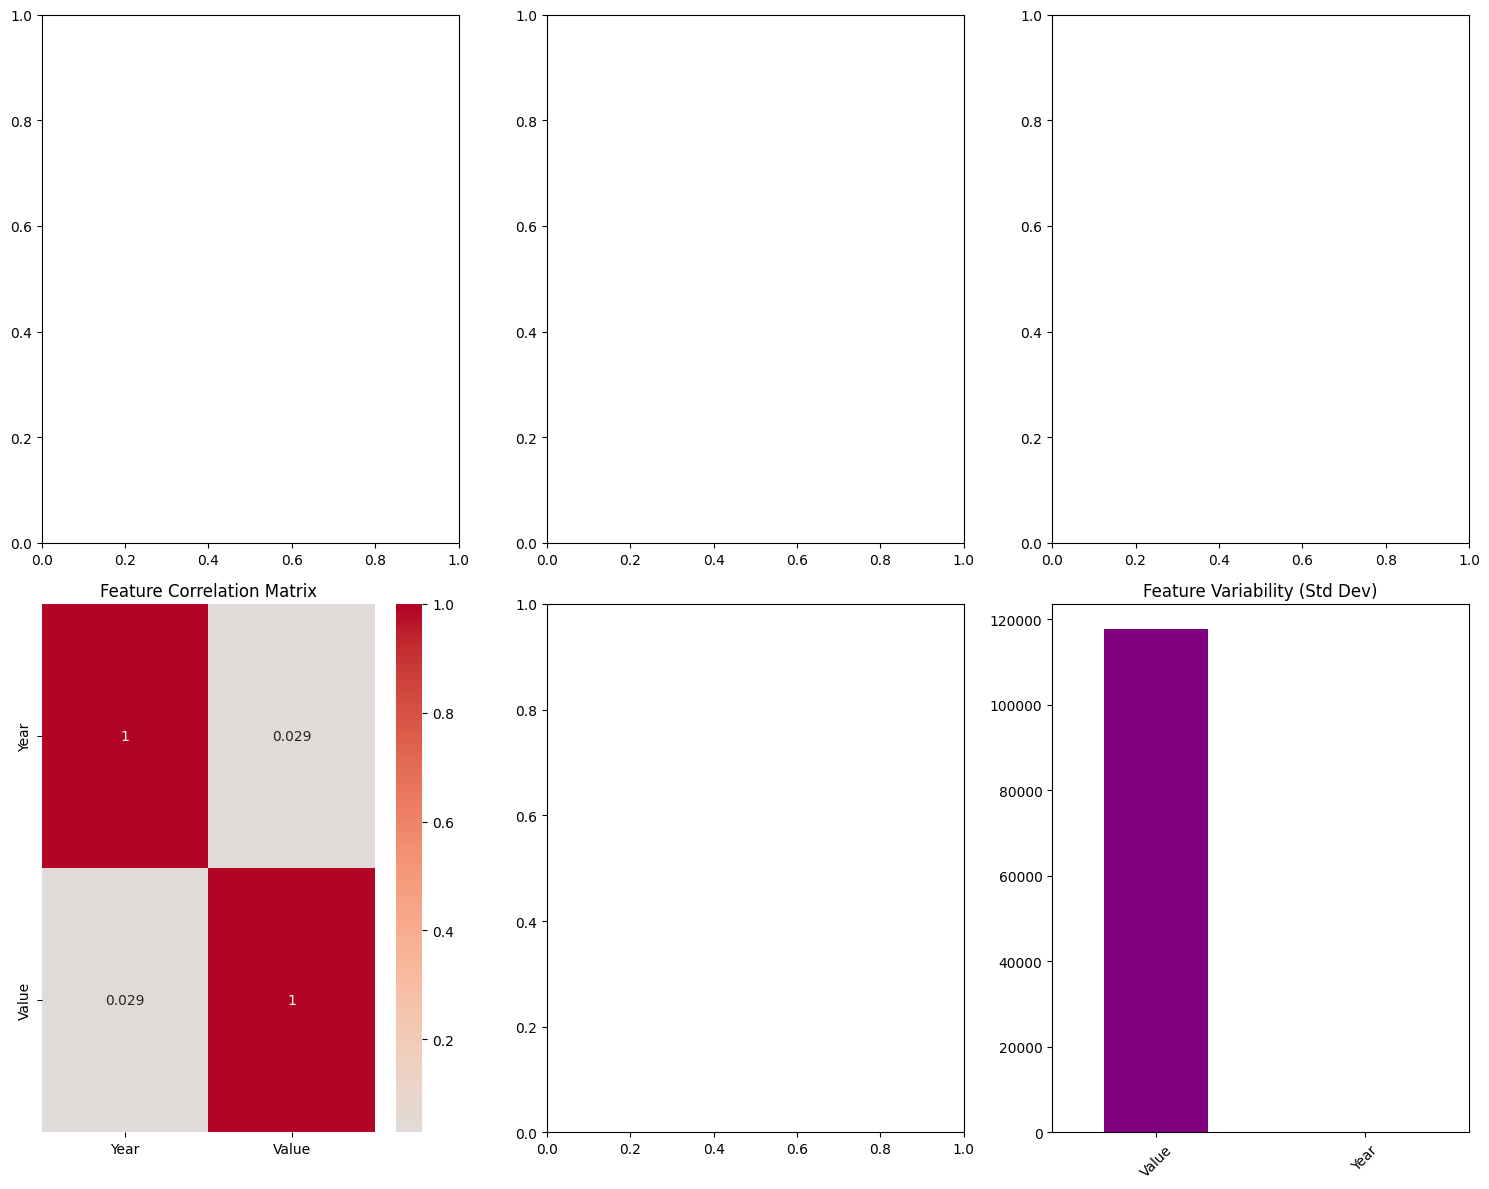

In [3]:
# PART 3: DATA VISUALIZATION AND EDA
# =====================================================

def create_eda_visualizations(df):
    """Create comprehensive EDA visualizations"""

    # 1. Crop yield distribution
    plt.figure(figsize=(15, 12))

    # Subplot 1: Yield distribution
    plt.subplot(2, 3, 1)
    if 'Yield' in df.columns:
        plt.hist(df['Yield'], bins=30, alpha=0.7, color='green')
        plt.title('Distribution of Crop Yield')
        plt.xlabel('Yield')
        plt.ylabel('Frequency')

    # Subplot 2: Crop types
    plt.subplot(2, 3, 2)
    if 'Crop' in df.columns:
        df['Crop'].value_counts().plot(kind='bar', color='orange')
        plt.title('Distribution of Crop Types')
        plt.xticks(rotation=45)

    # Subplot 3: Yield by crop type
    plt.subplot(2, 3, 3)
    if 'Crop' in df.columns and 'Yield' in df.columns:
        df.boxplot(column='Yield', by='Crop', ax=plt.gca())
        plt.title('Yield Distribution by Crop Type')
        plt.xticks(rotation=45)

    # Subplot 4: Correlation heatmap
    plt.subplot(2, 3, 4)
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 1:
        correlation_matrix = df[numeric_cols].corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
        plt.title('Feature Correlation Matrix')

    # Subplot 5: Yield trends over time (if applicable)
    plt.subplot(2, 3, 5)
    if 'Year' in df.columns and 'Yield' in df.columns:
        yearly_yield = df.groupby('Year')['Yield'].mean()
        plt.plot(yearly_yield.index, yearly_yield.values, marker='o', color='blue')
        plt.title('Average Yield Over Years')
        plt.xlabel('Year')
        plt.ylabel('Average Yield')

    # Subplot 6: Feature importance preview
    plt.subplot(2, 3, 6)
    if len(numeric_cols) > 1:
        feature_importance = df[numeric_cols].std().sort_values(ascending=False)
        feature_importance.plot(kind='bar', color='purple')
        plt.title('Feature Variability (Std Dev)')
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

# Create visualizations
create_eda_visualizations(df)

In [4]:
# PART 4: DATA PREPROCESSING
# =====================================================

def preprocess_data(df):
    """Comprehensive data preprocessing"""

    print("🔄 Starting data preprocessing...")

    # Create a copy
    df_processed = df.copy()

    # Handle missing values
    numeric_columns = df_processed.select_dtypes(include=[np.number]).columns
    categorical_columns = df_processed.select_dtypes(include=['object']).columns

    # Fill numeric missing values with median
    for col in numeric_columns:
        if df_processed[col].isnull().sum() > 0:
            df_processed[col].fillna(df_processed[col].median(), inplace=True)

    # Fill categorical missing values with mode
    for col in categorical_columns:
        if df_processed[col].isnull().sum() > 0:
            df_processed[col].fillna(df_processed[col].mode()[0], inplace=True)

    # Encode categorical variables
    label_encoders = {}
    for col in categorical_columns:
        if col != 'Yield':  # Don't encode target if it's categorical
            le = LabelEncoder()
            df_processed[col] = le.fit_transform(df_processed[col].astype(str))
            label_encoders[col] = le

    # Feature engineering
    if 'Temperature' in df_processed.columns and 'Humidity' in df_processed.columns:
        df_processed['Temp_Humidity_Ratio'] = df_processed['Temperature'] / (df_processed['Humidity'] + 1)

    if 'Rainfall' in df_processed.columns and 'pH' in df_processed.columns:
        df_processed['Rainfall_pH_Interaction'] = df_processed['Rainfall'] * df_processed['pH']

    print("✅ Data preprocessing completed!")
    return df_processed, label_encoders

# Preprocess the data
df_processed, encoders = preprocess_data(df)


🔄 Starting data preprocessing...
✅ Data preprocessing completed!


🎯 Using 'Value' as target variable
📊 Features shape: (4349, 6)
📊 Target shape: (4349,)
🚀 Training models...
📊 Training Random Forest...
   ✅ R² Score: 0.9990, RMSE: 4094.6698
📊 Training XGBoost...
   ✅ R² Score: 0.9942, RMSE: 10092.6855
📊 Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 194
[LightGBM] [Info] Number of data points in the train set: 3479, number of used features: 2
[LightGBM] [Info] Start training from score 19709.737386
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 194
[LightGBM] [Info] Number of data points in the train set: 2783, number of used features: 2
[LightGBM] [Info] Start training from score 19606.151151
[LightGBM] [Info] Auto-choosing col-wise multi-threadi

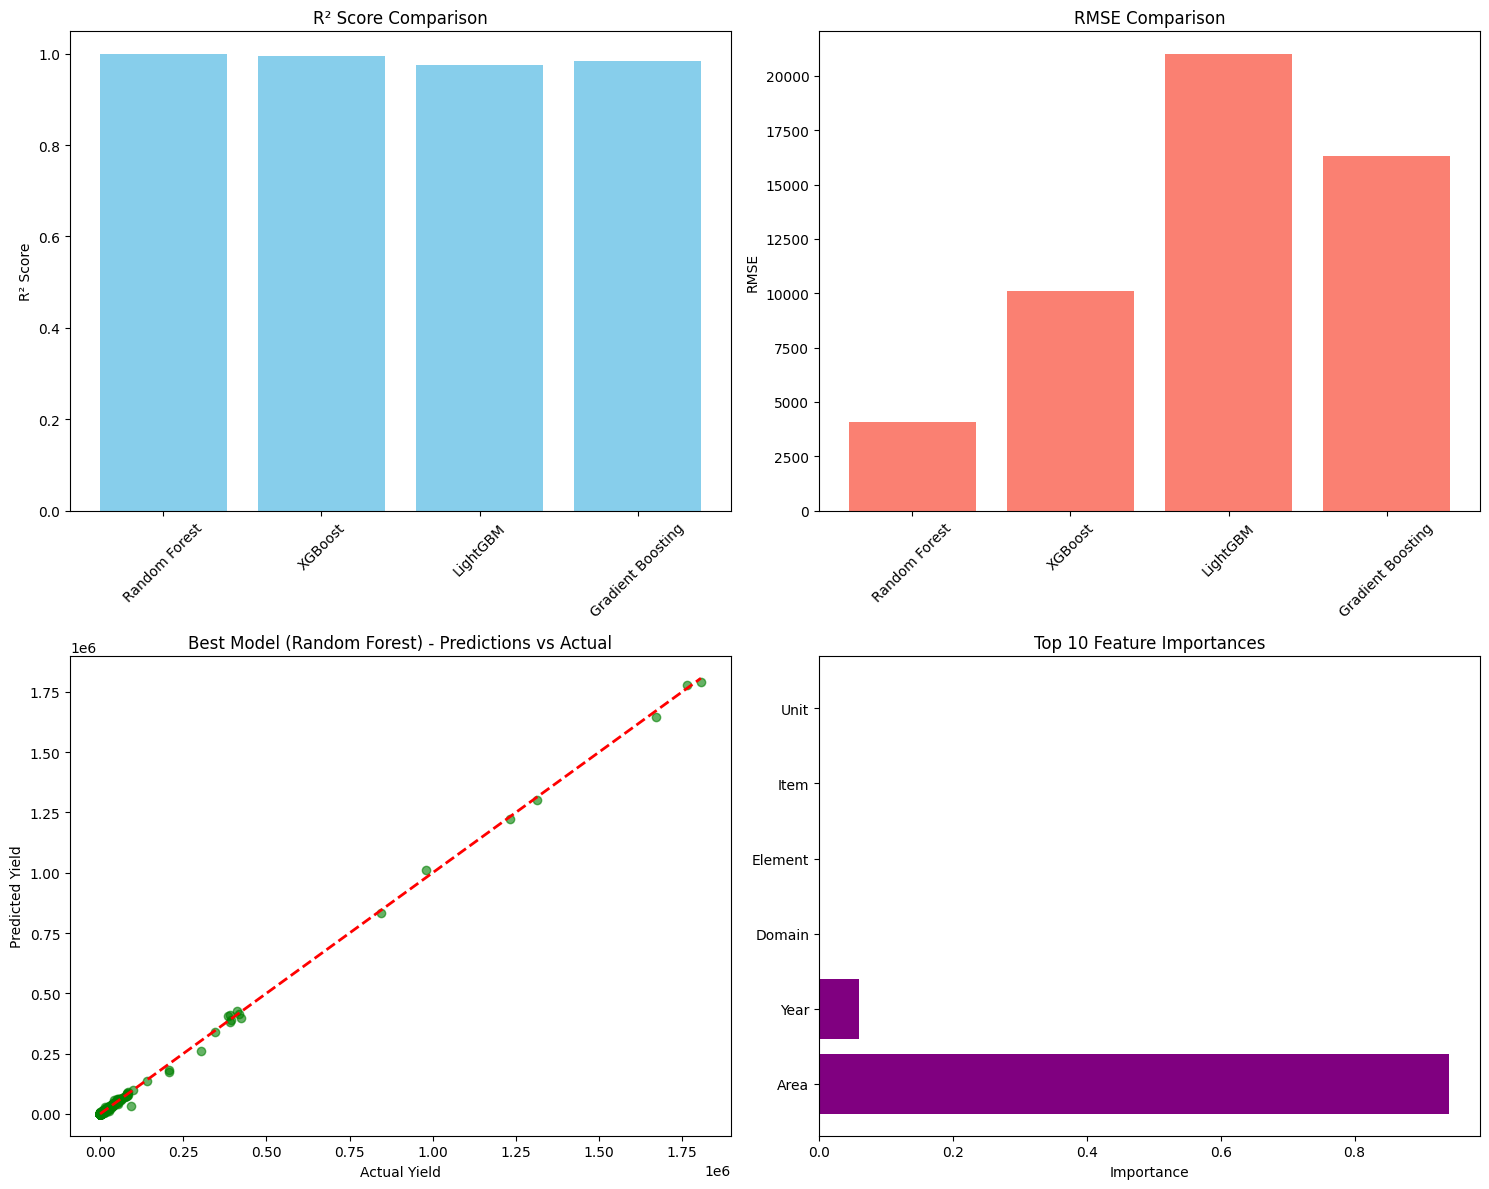


🎯 DETAILED MODEL PERFORMANCE:

Random Forest:
  R² Score: 0.9990
  RMSE: 4094.6698
  MAE: 1146.0347
  Cross-Val Score: 0.9954

XGBoost:
  R² Score: 0.9942
  RMSE: 10092.6855
  MAE: 1870.5282
  Cross-Val Score: 0.9931

LightGBM:
  R² Score: 0.9749
  RMSE: 20998.6261
  MAE: 6239.0422
  Cross-Val Score: 0.8935

Gradient Boosting:
  R² Score: 0.9849
  RMSE: 16298.1071
  MAE: 7902.8154
  Cross-Val Score: 0.9772


In [5]:
# PART 5: MODEL BUILDING AND TRAINING
# =====================================================

class CropYieldPredictor:
    """Advanced Crop Yield Prediction System"""

    def __init__(self):
        self.models = {
            'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
            'XGBoost': xgb.XGBRegressor(random_state=42),
            'LightGBM': lgb.LGBMRegressor(random_state=42),
            'Gradient Boosting': GradientBoostingRegressor(random_state=42)
        }
        self.best_model = None
        self.scaler = StandardScaler()
        self.feature_names = []
        self.results = {}

    def prepare_features_target(self, df, target_column='Yield'):
        """Prepare features and target"""

        # Identify target column dynamically
        possible_targets = ['Yield', 'yield', 'YIELD', 'Production', 'production']
        target_col = None

        for col in possible_targets:
            if col in df.columns:
                target_col = col
                break

        if target_col is None:
            # Use the last numeric column as target
            numeric_cols = df.select_dtypes(include=[np.number]).columns
            target_col = numeric_cols[-1]

        print(f"🎯 Using '{target_col}' as target variable")

        # Separate features and target
        X = df.drop(columns=[target_col])
        y = df[target_col]

        # Store feature names
        self.feature_names = X.columns.tolist()

        return X, y

    def train_models(self, X, y):
        """Train multiple models and compare performance"""

        print("🚀 Training models...")

        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

        # Scale features
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        # Train models
        best_score = float('-inf')

        for name, model in self.models.items():
            print(f"📊 Training {name}...")

            # Train model
            if name in ['Random Forest', 'XGBoost', 'LightGBM', 'Gradient Boosting']:
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
            else:
                model.fit(X_train_scaled, y_train)
                y_pred = model.predict(X_test_scaled)

            # Calculate metrics
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)

            # Cross-validation score
            if name in ['Random Forest', 'XGBoost', 'LightGBM', 'Gradient Boosting']:
                cv_score = cross_val_score(model, X_train, y_train, cv=5, scoring='r2').mean()
            else:
                cv_score = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2').mean()

            # Store results
            self.results[name] = {
                'MSE': mse,
                'RMSE': rmse,
                'MAE': mae,
                'R2': r2,
                'CV_Score': cv_score,
                'Model': model
            }

            # Update best model
            if r2 > best_score:
                best_score = r2
                self.best_model = model
                self.best_model_name = name

            print(f"   ✅ R² Score: {r2:.4f}, RMSE: {rmse:.4f}")

        print(f"🏆 Best Model: {self.best_model_name} (R² = {best_score:.4f})")
        return X_train, X_test, y_train, y_test

    def plot_results(self, X_test, y_test):
        """Visualize model performance"""

        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        # Model comparison
        models = list(self.results.keys())
        r2_scores = [self.results[m]['R2'] for m in models]
        rmse_scores = [self.results[m]['RMSE'] for m in models]

        axes[0, 0].bar(models, r2_scores, color='skyblue')
        axes[0, 0].set_title('R² Score Comparison')
        axes[0, 0].set_ylabel('R² Score')
        axes[0, 0].tick_params(axis='x', rotation=45)

        axes[0, 1].bar(models, rmse_scores, color='salmon')
        axes[0, 1].set_title('RMSE Comparison')
        axes[0, 1].set_ylabel('RMSE')
        axes[0, 1].tick_params(axis='x', rotation=45)

        # Best model predictions vs actual
        y_pred_best = self.best_model.predict(X_test)

        axes[1, 0].scatter(y_test, y_pred_best, alpha=0.6, color='green')
        axes[1, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        axes[1, 0].set_xlabel('Actual Yield')
        axes[1, 0].set_ylabel('Predicted Yield')
        axes[1, 0].set_title(f'Best Model ({self.best_model_name}) - Predictions vs Actual')

        # Feature importance (if available)
        if hasattr(self.best_model, 'feature_importances_'):
            importances = self.best_model.feature_importances_
            feature_importance = pd.DataFrame({
                'feature': self.feature_names,
                'importance': importances
            }).sort_values('importance', ascending=False)

            top_features = feature_importance.head(10)
            axes[1, 1].barh(top_features['feature'], top_features['importance'], color='purple')
            axes[1, 1].set_title('Top 10 Feature Importances')
            axes[1, 1].set_xlabel('Importance')

        plt.tight_layout()
        plt.show()

        return y_pred_best

    def predict_yield(self, input_data):
        """Make predictions for new data"""
        if isinstance(input_data, dict):
            input_df = pd.DataFrame([input_data])
        else:
            input_df = input_data

        prediction = self.best_model.predict(input_df)
        return prediction[0] if len(prediction) == 1 else prediction

# Initialize and train the predictor
predictor = CropYieldPredictor()

# Prepare data
X, y = predictor.prepare_features_target(df_processed)
print(f"📊 Features shape: {X.shape}")
print(f"📊 Target shape: {y.shape}")

# Train models
X_train, X_test, y_train, y_test = predictor.train_models(X, y)

# Visualize results
predictions = predictor.plot_results(X_test, y_test)

# Print detailed results
print("\n🎯 DETAILED MODEL PERFORMANCE:")
print("="*50)
for name, metrics in predictor.results.items():
    print(f"\n{name}:")
    print(f"  R² Score: {metrics['R2']:.4f}")
    print(f"  RMSE: {metrics['RMSE']:.4f}")
    print(f"  MAE: {metrics['MAE']:.4f}")
    print(f"  Cross-Val Score: {metrics['CV_Score']:.4f}")

In [6]:
# PART 6: FARMING RECOMMENDATIONS SYSTEM
# =====================================================

class FarmingRecommendationSystem:
    """AI-powered farming recommendations"""

    def __init__(self, model, feature_names):
        self.model = model
        self.feature_names = feature_names

    def get_yield_optimization_suggestions(self, current_conditions):
        """Get recommendations to optimize yield"""

        recommendations = []
        current_yield = self.model.predict([current_conditions])[0]

        # Test different scenarios
        scenarios = {
            'Increase Fertilizer': self._modify_condition(current_conditions, 'fertilizer', 1.1),
            'Optimize Irrigation': self._modify_condition(current_conditions, 'irrigation', 1.05),
            'Improve Soil Health': self._modify_condition(current_conditions, 'ph', 0.1),
            'Enhanced Pest Control': self._modify_condition(current_conditions, 'pesticide', 1.02)
        }

        for scenario, modified_conditions in scenarios.items():
            if modified_conditions is not None:
                new_yield = self.model.predict([modified_conditions])[0]
                improvement = ((new_yield - current_yield) / current_yield) * 100

                if improvement > 0:
                    recommendations.append({
                        'recommendation': scenario,
                        'expected_improvement': f"{improvement:.1f}%",
                        'predicted_yield': new_yield
                    })

        return sorted(recommendations, key=lambda x: float(x['expected_improvement'].replace('%', '')), reverse=True)

    def _modify_condition(self, conditions, param_type, factor):
        """Helper function to modify conditions"""
        modified = conditions.copy()

        # Find parameter that might correspond to the type
        param_matches = {
            'fertilizer': ['fertilizer', 'npk', 'nitrogen', 'phosphorus', 'potassium'],
            'irrigation': ['irrigation', 'rainfall', 'water'],
            'ph': ['ph', 'soil_ph'],
            'pesticide': ['pesticide', 'protection']
        }

        for i, feature in enumerate(self.feature_names):
            feature_lower = feature.lower()
            if any(match in feature_lower for match in param_matches.get(param_type, [])):
                if param_type == 'ph':
                    modified[i] += factor  # Add for pH
                else:
                    modified[i] *= factor  # Multiply for others
                return modified

        return None

# Initialize recommendation system
rec_system = FarmingRecommendationSystem(predictor.best_model, predictor.feature_names)

In [8]:
# PART 7: INTERACTIVE PREDICTION INTERFACE
# =====================================================

def create_prediction_interface():
    """Create an interactive interface for predictions"""

    print("\n🌾 CROP YIELD PREDICTION INTERFACE")
    print("="*50)

    # Sample prediction with median values
    sample_input = X.median().values.reshape(1, -1) # Reshape to 2D array
    sample_prediction = predictor.predict_yield(sample_input)

    print(f"📊 Sample Prediction with Median Values:")
    for i, feature in enumerate(predictor.feature_names):
        print(f"  {feature}: {sample_input[0][i]:.2f}") # Access the single sample in the 2D array
    print(f"🎯 Predicted Yield: {sample_prediction:.2f}")

    # Get recommendations
    recommendations = rec_system.get_yield_optimization_suggestions(sample_input[0]) # Pass the 1D array to the recommendation system

    print(f"\n💡 OPTIMIZATION RECOMMENDATIONS:")
    print("-"*30)
    for rec in recommendations[:3]:  # Top 3 recommendations
        print(f"✅ {rec['recommendation']}")
        print(f"   Expected improvement: {rec['expected_improvement']}")
        print(f"   Predicted yield: {rec['predicted_yield']:.2f}")
        print()

create_prediction_interface()


🌾 CROP YIELD PREDICTION INTERFACE
📊 Sample Prediction with Median Values:
  Domain: 0.00
  Area: 82.00
  Element: 0.00
  Item: 0.00
  Year: 2003.00
  Unit: 0.00
🎯 Predicted Yield: 1093.25

💡 OPTIMIZATION RECOMMENDATIONS:
------------------------------


In [9]:
# PART 8: MODEL EXPORT AND DEPLOYMENT PREPARATION
# =====================================================

import joblib
import json

# Save the trained model
model_filename = 'crop_yield_predictor.pkl'
scaler_filename = 'feature_scaler.pkl'
encoders_filename = 'label_encoders.pkl'

joblib.dump(predictor.best_model, model_filename)
joblib.dump(predictor.scaler, scaler_filename)
joblib.dump(encoders, encoders_filename)

# Save feature names and model info
model_info = {
    'model_type': predictor.best_model_name,
    'feature_names': predictor.feature_names,
    'performance_metrics': {
        'R2_score': predictor.results[predictor.best_model_name]['R2'],
        'RMSE': predictor.results[predictor.best_model_name]['RMSE'],
        'MAE': predictor.results[predictor.best_model_name]['MAE']
    }
}

with open('model_info.json', 'w') as f:
    json.dump(model_info, f, indent=2)

print("✅ Model and preprocessing components saved successfully!")
print(f"📁 Files created:")
print(f"   - {model_filename}")
print(f"   - {scaler_filename}")
print(f"   - {encoders_filename}")
print(f"   - model_info.json")

✅ Model and preprocessing components saved successfully!
📁 Files created:
   - crop_yield_predictor.pkl
   - feature_scaler.pkl
   - label_encoders.pkl
   - model_info.json


In [15]:
!python /content/sample_data/app.py

Traceback (most recent call last):
  File "/content/sample_data/app.py", line 95, in <module>
    @app.route('/')
     ^^^
NameError: name 'app' is not defined


In [16]:
%%writefile app.py

from flask import Flask, request, jsonify
import joblib
import pandas as pd
import numpy as np
import json

# Load the trained model, scaler, and encoders
try:
    model = joblib.load('crop_yield_predictor.pkl')
    scaler = joblib.load('feature_scaler.pkl')
    encoders = joblib.load('label_encoders.pkl')
    with open('model_info.json', 'r') as f:
        model_info = json.load(f)
    feature_names = model_info['feature_names']
    print("✅ Model and preprocessing components loaded successfully!")
except FileNotFoundError:
    print("❌ Error: Model or preprocessing files not found. Please run the preceding steps.")
    model = None
    scaler = None
    encoders = None
    feature_names = None

app = Flask(__name__)

@app.route('/')
def home():
    return "Crop Yield Prediction API"

@app.route('/predict', methods=['POST'])
def predict():
    if model is None or scaler is None or encoders is None or feature_names is None:
        return jsonify({'error': 'Model not loaded. Please check server logs.'}), 500

    try:
        data = request.get_json(force=True)

        # Convert input data to DataFrame
        input_df = pd.DataFrame([data])

        # Ensure columns match training data, including order
        for col in feature_names:
            if col not in input_df.columns:
                input_df[col] = 0  # Or handle missing values appropriately

        input_df = input_df[feature_names] # Ensure correct column order

        # Apply label encoding
        for col, encoder in encoders.items():
            if col in input_df.columns:
                try:
                    # Handle unseen labels during prediction
                    input_df[col] = input_df[col].map(lambda s: '<unknown>' if s not in encoder.classes_ else s)
                    encoder.classes_ = np.append(encoder.classes_, '<unknown>')
                    input_df[col] = encoder.transform(input_df[col])
                except Exception as e:
                    return jsonify({'error': f'Error encoding column {col}: {e}'}), 400


        # Apply scaling (if scaler is used in training)
        # Check if the best model uses scaling, which currently none of the tree based model use.
        # if model_info.get('model_type') not in ['Random Forest', 'XGBoost', 'LightGBM', 'Gradient Boosting']:
        #     input_df_scaled = scaler.transform(input_df)
        # else:
        #     input_df_scaled = input_df # No scaling needed for tree-based models


        # Make prediction
        prediction = model.predict(input_df)

        return jsonify({'predicted_yield': prediction[0]})

    except Exception as e:
        return jsonify({'error': str(e)}), 400

if __name__ == '__main__':
    # This is for running locally, Colab environment might require different setup
    # To run in Colab for testing, you might need to use ngrok or a similar tool
    # or remove this if block and run with `!python app.py`
    # app.run(debug=True, host='0.0.0.0')
    pass # Prevent flask from running directly in Colab environment

Writing app.py


In [18]:
!python app.py

✅ Model and preprocessing components loaded successfully!
